In [59]:
%load_ext autoreload
%autoreload 2

import os
import preprocessing
from gensim import corpora

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
from gensim.models.doc2vec import TaggedDocument

def texts_corpus(textdir='data/texts/'):
    files = os.listdir(textdir)
    corpus = []
    source_enum = {}
    for i, file in enumerate(files):
        if '.txt' not in file:
            #print('Skipping index: ' + str(i))
            continue
        with open(textdir + file) as f:
            t = f.read()
            #yield gensim.utils.simple_preprocess(t.replace('\n', ' '))
            corpus.append(
                TaggedDocument(
                    #words=[word.lower() for word in t.replace('\n', ' ').split()],
                    words=preprocessing.doc_preprocessor(t, lemmatize=False),
                    tags=[file.strip('.txt')])
                    #tags=[i])
            )
        source_enum[i] = file.strip('.txt')
            
    return corpus, source_enum
            
train_corpus, source_enum = texts_corpus()

In [143]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=100)
model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
#model.save('data/doc2vec.model')

CPU times: user 1h 2min 23s, sys: 14.7 s, total: 1h 2min 37s
Wall time: 22min 3s


In [211]:
fu_dict = {
    paper['id'].split('/')[-1]: paper \
    for paper in preprocessing.flat_unique()
}
id_term = {}
for key in fu_dict.keys():
    id_term[key] = [
        tag['term'].split('.')[1] for tag in fu_dict[key]['tags'] \
         if tag['term'].split('.')[0] == 'q-fin'
    ][0]

In [212]:
#set(id_term.values())
colors = {
    'CP': 'red', 'EC': 'blue', 
    'GN': 'green', 'MF': 'grey', 
    'PM': 'black', 'PR': 'yellow',
    'RM': 'violet', 'ST': 'orange',
    'TR': 'pink'}

In [268]:
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

G = nx.Graph()

#for i in tqdm(range(0, len(model.docvecs), 10)):
for i in range(0, len(model.docvecs), 10):
    ivec = model.infer_vector(doc_words=train_corpus[i].words)
    sims = model.docvecs.most_similar([ivec], topn=len(model.docvecs))
    
    this_node = sims[0][0]
    #for j in range(1, len(sims)):
    # Add most similar distance
    for j in range(1, 20):
        G.add_edge(this_node, sims[j][0], 
                   attr_dict={
                       'distance': (1-sims[j][1]), 
                       'color': colors[id_term[sims[j][0]]]
                   })

In [269]:
edge_colors = [e[2]['attr_dict']['color'] for e in G.edges(data=True)]
node_ids = [e[0] for e in G.nodes(data=True)]
node_colors = [colors[id_term[node_id]] for node_id in node_ids]

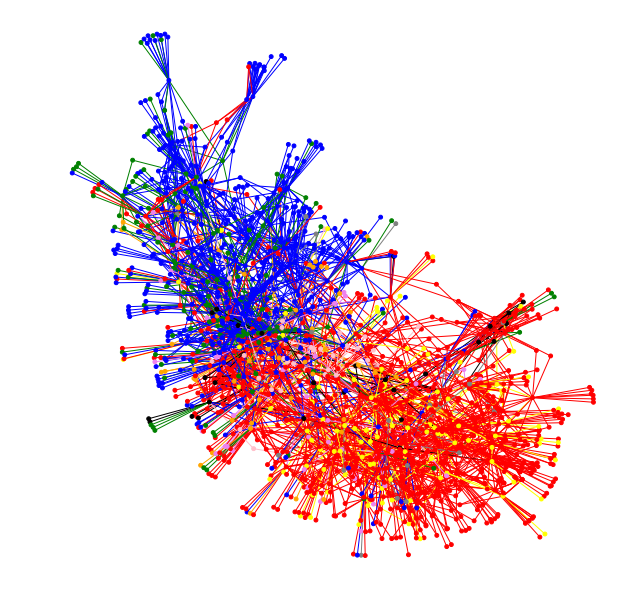

In [270]:
plt.figure(figsize=(8, 8))
nx.draw(G, edge_color=edge_colors, node_color=node_colors, node_size=15)
plt.savefig('data/graph.jpg')
plt.show()